<a href="https://colab.research.google.com/github/schen304joseph/HW3/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A12= 1.95841966952408
A21= 1.6891850023576693


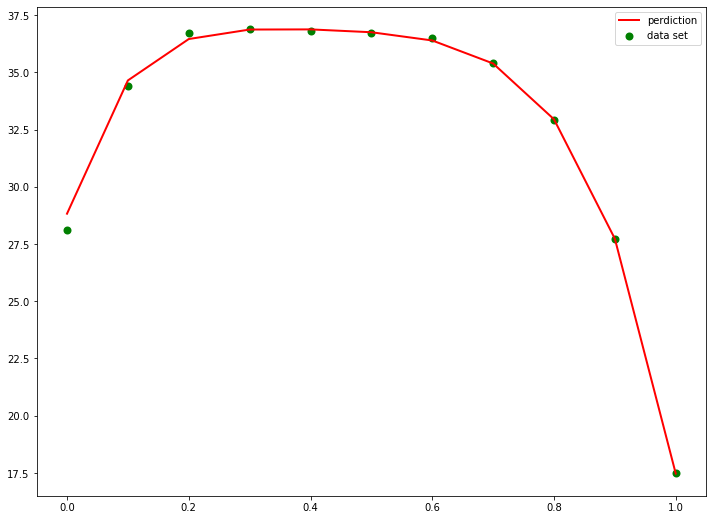

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

x1 = np.arange(start=0, stop=1.1, step=0.1)
p = np.array([28.1,34.4,36.7,36.9,36.8,36.7,36.5,35.4,32.9,27.7,17.5])

def psat (a1,a2,a3):
  return 10**(a1-(a2/(20+a3)))

def pval (x1,A12,A21):
  x2 = 1-x1
  return x1*np.exp(A12*((A21*x2)/(A12*x1+A21*x2))**2)*psat(8.07131,1730.63,233.426)+x2*np.exp(A21*((A12*x1)/(A12*x1+A21*x2))**2)*psat(7.43155,1554.679,240.337)

c, cov = curve_fit(pval,x1,p)

n = len(x1)
y=np.empty(n)
for i in range(n):
  y[i]=pval(x1[i],c[0],c[1])

plt.scatter(x1,p,color="green",label="data set",linewidth=2)
plt.plot(x1,y,color="red",label="perdiction",linewidth=2)
plt.legend()
print("A12=",c[0])
print("A21=",c[1])

|   iter    |  target   |    x1     |    x2     |
-------------------------------------------------
|  1        |  0.265    | -0.4979   |  0.8813   |
|  2        | -110.1    | -2.999    | -0.7907   |
|  3        | -26.91    | -2.119    | -1.631    |
|  4        | -2.856    | -1.882    | -0.6178   |
|  5        | -1.054    | -0.6194   |  0.1553   |
|  6        |  0.4249   | -0.5122   |  0.7965   |
|  7        |  0.4539   | -0.4767   |  0.8273   |
|  8        | -3.61     | -2.104    |  0.5152   |
|  9        |  0.3705   | -0.5095   |  0.8335   |
|  10       |  0.5169   | -0.4847   |  0.7122   |
|  11       | -0.1171   | -0.5528   |  0.4589   |
|  12       |  0.3635   | -0.5281   |  0.6528   |
|  13       |  0.5732   | -0.4594   |  0.7557   |
|  14       |  0.665    | -0.4175   |  0.727    |
|  15       | -5.892    | -2.109    | -0.3733   |


NameError: ignored

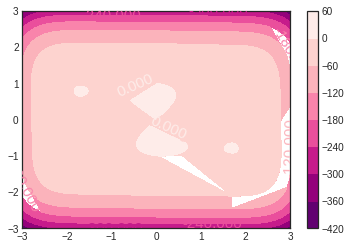

In [76]:
!pip install bayesian-optimization

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
from bayes_opt import BayesianOptimization

def black_box_function(x1, x2):
  return -((4-2.1*x1**2+((x1**4)/3))*x1**2+x1*x2+(-4+4*(x2**2))*(x2**2))

x1 = np.linspace(-3, 3, 500)
x2 = np.linspace(-3, 3, 500)
x1, x2 = np.meshgrid(x1, x2)
Z = black_box_function(x1, x2)
plt.figure()

contours=plt.contourf(x1, x2, Z,cmap='RdPu_r')
plt.clabel(contours, inline=True, fontsize=15)
plt.colorbar()

pbounds = {'x1': (-3, 3), 'x2': (-2, 2)}
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=1,
)
optimizer.maximize(init_points=5,n_iter=10,)

for _ in range(5):
    next_point = optimizer.suggest(utility)
    target = black_box_function(**next_point)
    optimizer.register(params=next_point, target=target)
    
    print(target, next_point)
print(optimizer.max)


In [49]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
import pyro.contrib.gp as gp

assert pyro.__version__.startswith('1.7.0')
pyro.set_rng_seed(1)

def f(x1,x2):
    return (4-2.1*x1**2+((x1**4)/3))*(x1**2)+x1*x2+(-4+4*(x2**2))*(x2**2)

x1 = torch.linspace(-3, 3)
x2 = torch.linspace(-2, 2)

x1 = torch.tensor([0.0, 0.33, 0.66, 1.0])
x2 = torch.tensor([0.0, 0.33, 0.66, 1.0])
y=f(x1,x2)
pmodel = gp.models.GPRegression(x1,x2, y, gp.kernels.Matern52(input_dim=1),
                                 noise=torch.tensor(0.1), jitter=1.0e-4)

TypeError: ignored

In [42]:
#!pip install torch
#!pip install botorch
!pip install 'git+https://github.com/facebook/Ax.git#egg=ax-platform'
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior


class SimpleCustomGP(ExactGP, GPyTorchModel):

    _num_outputs = 1  # to inform GPyTorchModel API
    
    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

from botorch.fit import fit_gpytorch_model

def _get_and_fit_simple_custom_gp(Xs, Ys, **kwargs):
    model = SimpleCustomGP(Xs[0], Ys[0])
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

import random
import numpy as np

def branin(parameterization, *args):
    x1, x2 = parameterization["x1"], parameterization["x2"]
    y = (x2 - 5.1 / (4 * np.pi ** 2) * x1 ** 2 + 5 * x1 / np.pi - 6) ** 2
    y += 10 * (1 - 1 / (8 * np.pi)) * np.cos(x1) + 10
    # let's add some synthetic observation noise
    y += random.normalvariate(0, 0.1)
    return {"branin": (y, 0.0)}

from ax import ParameterType, RangeParameter, SearchSpace

search_space = SearchSpace(
    parameters=[
        RangeParameter(
            name="x1", parameter_type=ParameterType.FLOAT, lower=-5, upper=10
        ),
        RangeParameter(
            name="x2", parameter_type=ParameterType.FLOAT, lower=0, upper=15
        ),
    ]
)

from ax import SimpleExperiment

exp = SimpleExperiment(
    name="test_branin",
    search_space=search_space,
    evaluation_function=branin,
    objective_name="branin",
    minimize=True,
)

from ax.modelbridge import get_sobol

sobol = get_sobol(exp.search_space)
exp.new_batch_trial(generator_run=sobol.gen(5))

from ax.modelbridge.factory import get_botorch

for i in range(5):
    print(f"Running optimization batch {i+1}/5...")
    model = get_botorch(
        experiment=exp,
        data=exp.eval(),
        search_space=exp.search_space,
        model_constructor=_get_and_fit_simple_custom_gp,
    )
    batch = exp.new_trial(generator_run=model.gen(1))
    
print("Done!")

  Cloning https://github.com/facebook/Ax.git to /tmp/pip-install-_4a765wb/ax-platform_c2fe1285463a4f6db3bc07f3bdeae10e
  Running command git clone -q https://github.com/facebook/Ax.git /tmp/pip-install-_4a765wb/ax-platform_c2fe1285463a4f6db3bc07f3bdeae10e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


ImportError: ignored

In [5]:
import numpy as np

def objective(x):
    """Objective function to minimize"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Return the value of the polynomial
    return f(x) * 0.05
from hyperopt import hp
# Create the domain space
space = hp.uniform('x', -5, 6)
from hyperopt import tpe
# Create the algorithm
tpe_algo = tpe.suggest
from hyperopt import Trials
# Create a trials object
tpe_trials = Trials()

from hyperopt import fmin

# Run 2000 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, 
                algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000)

print(tpe_best)

100%|██████████| 2000/2000 [00:18<00:00, 110.55it/s, best loss: -219.80120142624597]
{'x': 4.877991018817576}


Next point to probe is: {'x1': -0.4978679717845562, 'x2': 0.8812979737686324}
Found the target value to be: 0.2650082867644827


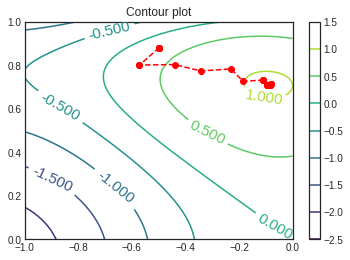

In [131]:
x1 = np.linspace(-1, 0, 500)
x2 = np.linspace(0, 1, 500)
x1, x2 = np.meshgrid(x1, x2)
Z = black_box_function(x1, x2)
fig = plt.figure()
plt.title('Contour plot')
contours=plt.contour(x1, x2, Z,cmap='viridis')
plt.clabel(contours, inline=True, fontsize=15)
plt.colorbar()


def black_box_function(x1, x2):
  return -((4-2.1*x1**2+((x1**4)/3))*x1**2+x1*x2+(-4+4*(x2**2))*(x2**2))

optimizer = BayesianOptimization(
    f=None,
    pbounds={'x1': (-3, 3), 'x2': (-2, 2)},
    verbose=2,
    random_state=1,
)
from bayes_opt import UtilityFunction

utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)
next_point_to_probe = optimizer.suggest(utility)
print("Next point to probe is:", next_point_to_probe)
target = black_box_function(**next_point_to_probe)
print("Found the target value to be:", target)
optimizer.register(
    params=next_point_to_probe,
    target=target,
)
i=0
datax1=np.zeros(50)
datax2=np.zeros(50)
for i in range(50):
    next_point = optimizer.suggest(utility)
    target = black_box_function(**next_point)
    optimizer.register(params=next_point, target=target)
    #print(optimizer['target'])
    #print(optimizer.max['params']['x1'])
    #plt.plot(optimizer.max['params']['x1'],optimizer.max['params']['x2'],'ro--')
    datax1[i]=(optimizer.max['params']['x1'])
    datax2[i]=(optimizer.max['params']['x2'])
    i+=1
plt.plot(datax1,datax2,'ro--')